In [1]:
!pip install scikit-plot

You should consider upgrading via the 'C:\Users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install cutmix-keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
from cutmix_keras import CutMixImageDataGenerator  # Import CutMix

In [4]:
import os 
import timeit
import numpy as np
import random as rn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import pydot
from sklearn.metrics import classification_report, confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
# Importing tensorflow
import tensorflow as tf
# Importing the Keras libraries and packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import metrics
from keras.initializers import GlorotNormal
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import activations
from tensorflow.keras import initializers
import scikitplot as skplt

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Convolution2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.initializers import GlorotNormal

In [6]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import SpecificityAtSensitivity

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [8]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [9]:
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Function to be used later on the notebook.

In [11]:
# Plot the loss function. (Train, Validation)
def plot_loss(history, title_label, n):
    plt.semilogy(history.epoch,  history.history['loss'], color=colors[n], label='Train '+title_label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color=colors[n], label='Val '+title_label, linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [12]:
# Plot the model accuracy. (Train, Validation) 
def plot_acc(history, title_label, n):
    plt.semilogy(history.epoch,  history.history['accuracy'], color=colors[n], label='Train '+title_label)
    plt.semilogy(history.epoch,  history.history['val_accuracy'], color=colors[n], label='Val '+title_label, linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.legend()

In [13]:
# Plot the model metrics,
def plot_metrics(history):
    metrics = ['precision', 'recall', 'auc']
    for n, metric in enumerate(metrics):
        #name = metric.replace("_"," ").capitalize()
        name = metric.capitalize()
        plt.subplot(3, 2, n+1)  # adjust according to metrics
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    plt.legend()

In [14]:
# Plot roc curve.
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    auc_roc = roc_auc_score(labels, predictions)
    plt.plot(100*fp,100*tp,label=name +" (" + str(round(auc_roc, 3)) + ")",linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.title('ROC curve')
    plt.grid(True)
    plt.legend(loc='best')
    ax = plt.gca()
    ax.set_aspect('equal')

# Data exploration

In [15]:
train_directory = 'dataset/train'
validation_directory = 'dataset/validation'
test_directory = 'dataset/test'

In [16]:
import tensorflow as tf

In [17]:
tf.test.gpu_device_name()

''

In [18]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12516137864867898807]

In [19]:
train_normal = os.path.join(train_directory, 'normal')
train_opacity = os.path.join(train_directory, 'opacity')

validation_normal = os.path.join(validation_directory, 'normal')
validation_opacity = os.path.join(validation_directory, 'opacity')

test_normal = os.path.join(test_directory, 'normal')
test_opacity = os.path.join(test_directory, 'opacity')

In [20]:
df_train = pd.DataFrame()
df_train['data'] = ['normal']*len(os.listdir(train_normal)) +['ocapity']*len(os.listdir(train_opacity))
df_train['data'].value_counts(normalize= True)

ocapity    0.741889
normal     0.258111
Name: data, dtype: float64

<AxesSubplot:xlabel='count', ylabel='data'>

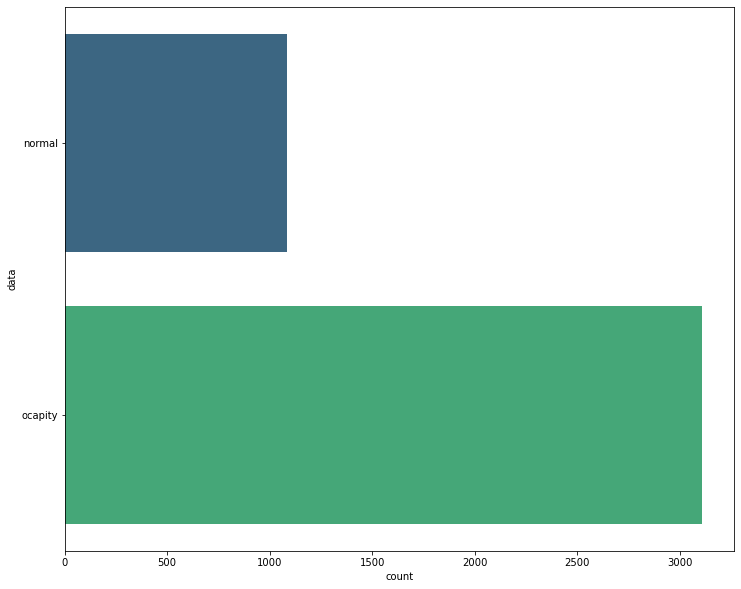

In [21]:
sns.countplot(y='data', data = df_train, palette='viridis', orient = 'h')

In [22]:
df_validation = pd.DataFrame()
df_validation['data'] = ['normal']*len(os.listdir(validation_normal)) +['ocapity']*len(os.listdir(validation_opacity))
df_validation['data'].value_counts(normalize= True)

ocapity    0.743269
normal     0.256731
Name: data, dtype: float64

<AxesSubplot:xlabel='count', ylabel='data'>

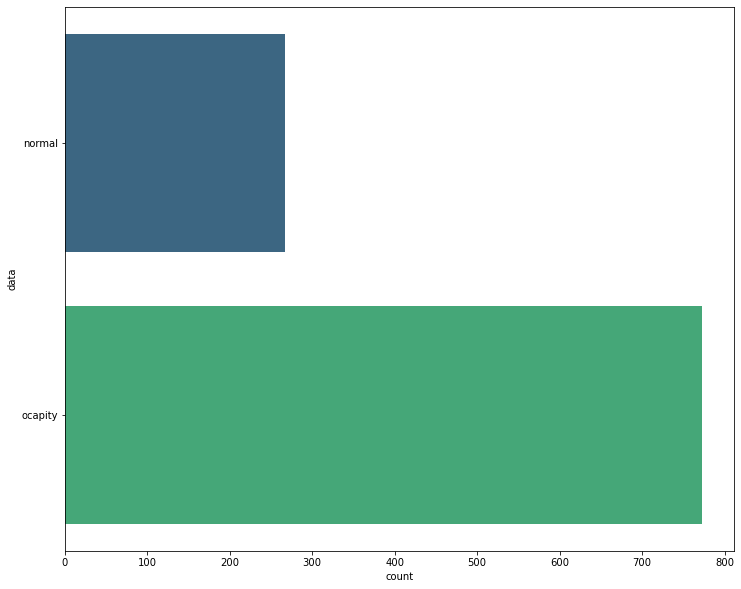

In [23]:
sns.countplot(y= 'data', data = df_validation, palette='viridis', orient='h')

In [24]:
df_test = pd.DataFrame()
df_test['data'] = ['normal']*len(os.listdir(test_normal)) +['ocapity']*len(os.listdir(test_opacity))
df_test['data'].value_counts(normalize= True)

ocapity    0.625
normal     0.375
Name: data, dtype: float64

<AxesSubplot:xlabel='count', ylabel='data'>

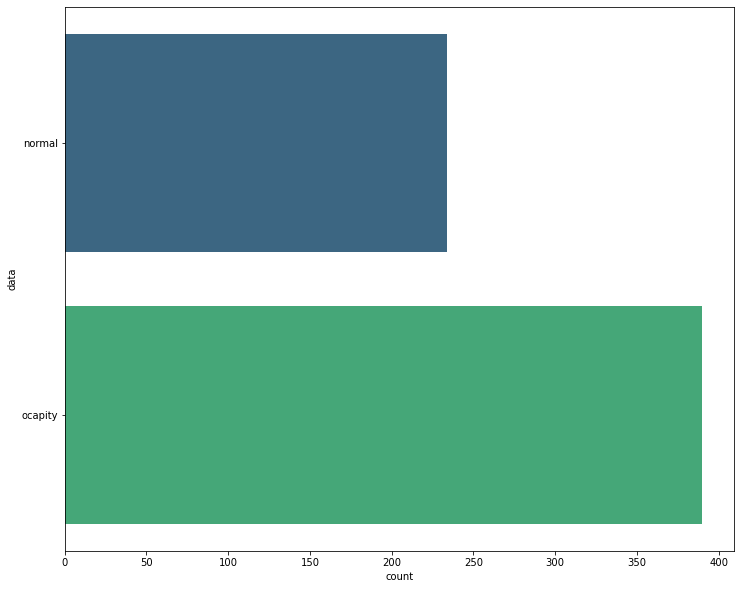

In [25]:
sns.countplot(y= 'data', data = df_test, palette='viridis', orient='h')

In [26]:
EPOCHS = 100
SEED = 42
WIDTH = 64 #150
HEIGHT = 64 #150 
DEPTH = 1
DEPTH_RGB = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)
TARGET_SIZE = (WIDTH , HEIGHT)
BATCH_SIZE = 128    
COLOR_MODE = 'grayscale'
CLASS_MODE =  'categorical'  
UNITS_DENSE = 32
FEATURES_MAP = 32

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   vertical_flip = False,
                                   horizontal_flip = False,
                                   rotation_range = 15,
                                   brightness_range = [0.9, 1.1],
                                   zoom_range = 0.2                                  
                                   )

train_generator_1 = train_datagen.flow_from_directory(
        directory = train_directory,  
        target_size = TARGET_SIZE,   
        batch_size = BATCH_SIZE,        
        color_mode = COLOR_MODE,
        class_mode= CLASS_MODE,    
        shuffle = True, # required
        )


train_generator_2 = train_datagen.flow_from_directory(
        directory = train_directory,  
        target_size = TARGET_SIZE,   
        batch_size = BATCH_SIZE,        
        color_mode = COLOR_MODE,
        class_mode= CLASS_MODE,    
        shuffle = True, # required
        )


train_generator = CutMixImageDataGenerator(generator1=train_generator_1, generator2=train_generator_2, 
                                             img_size=TARGET_SIZE[0], batch_size=BATCH_SIZE,)

Found 4192 images belonging to 2 classes.
Found 4192 images belonging to 2 classes.


In [28]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        directory = validation_directory,
        target_size = TARGET_SIZE,
        batch_size = BATCH_SIZE,
        color_mode = COLOR_MODE,
        class_mode=  CLASS_MODE,    
        shuffle = False, 
        )

Found 1040 images belonging to 2 classes.


In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        directory = test_directory,
        target_size = TARGET_SIZE,
        batch_size = BATCH_SIZE,
        color_mode = COLOR_MODE,
        class_mode = None,    
        shuffle = False,
        )

Found 624 images belonging to 2 classes.


In [30]:
TRAIN_STEPS_PER_EPOCH = np.math.ceil(train_generator.samples / train_generator.batch_size)
VALIDATION_STEPS_PER_EPOCH = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
TEST_STEPS_PER_EPOCH = np.math.ceil(test_generator.samples / test_generator.batch_size)

In [31]:
train_generator.class_indices

{'normal': 0, 'opacity': 1}

In [32]:
def our_model(filters, input_shape):
    model = Sequential([Conv2D(filters[0], (3, 3),  padding='valid', activation='relu', input_shape=input_shape),
                        #Conv2D(filters[1], (3, 3),  padding='same', kernel_regularizer=l2(0.001), activation='relu'),
                        MaxPool2D(pool_size=(2, 2)),
                        Conv2D(filters[1], (3, 3),  padding='valid',  kernel_regularizer=l2(0.001), activation='relu'), 
                        MaxPool2D(pool_size=(2, 2)),
                        #Dropout(0.5),
                        BatchNormalization(),
                        Flatten(),
                        Dense(units=128, activation='relu'),
                        Dense(units=64, activation='relu'),
                        Dropout(0.5),
                        #BatchNormalization(),
                        Dense(2, kernel_initializer=GlorotNormal(), activation='softmax')
                       ])
    return model

In [33]:
model = our_model([32, 16], INPUT_SHAPE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

In [34]:
METRICS = [
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

model.compile(loss= 'categorical_crossentropy', optimizer=Adam(lr = 1e-4, amsgrad = True), metrics=METRICS)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

CALLBACKS = [
             EarlyStopping(monitor='val_accuracy', verbose=1, patience=15, mode='auto', restore_best_weights=True), 
            TensorBoard(log_dir='my_log_dir', histogram_freq=1)
            ]

In [36]:
start = timeit.default_timer()

history = model.fit(
      train_generator,  
      steps_per_epoch = train_generator.get_steps_per_epoch(), #TRAIN_STEPS_PER_EPOCH,    
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  
      shuffle= False,   
      callbacks = CALLBACKS,
      verbose = 1, 
)

stop = timeit.default_timer()

print('Time: ', (stop - start)/60)

model.save('model_base')

Epoch 1/100
33/33 [==============================] - 130s 4s/step - loss: 0.6807 - fn: 1164.6765 - accuracy: 0.4419 - precision: 0.8147 - recall: 0.5936 - auc: 0.7026 - val_loss: 0.6274 - val_fn: 267.0000 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 0.7433 - val_auc: 0.8393
Epoch 2/100
33/33 [==============================] - 125s 4s/step - loss: 0.5031 - fn: 994.6765 - accuracy: 0.5611 - precision: 0.9345 - recall: 0.6805 - auc: 0.8664 - val_loss: 0.6200 - val_fn: 267.0000 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 0.7433 - val_auc: 0.8858
Epoch 3/100
33/33 [==============================] - 119s 4s/step - loss: 0.4711 - fn: 971.5588 - accuracy: 0.5671 - precision: 0.9422 - recall: 0.6852 - auc: 0.8841 - val_loss: 0.6044 - val_fn: 242.0000 - val_accuracy: 0.7673 - val_precision: 0.7673 - val_recall: 0.7673 - val_auc: 0.9014
Epoch 4/100
33/33 [==============================] - 120s 4s/step - loss: 0.4519 - fn: 942.0882 - accuracy: 0.5784 - precision: 0

INFO:tensorflow:Assets written to: model_base\assets


In [37]:
model.save("model_base")

INFO:tensorflow:Assets written to: model_base\assets


In [38]:
# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("my_model")

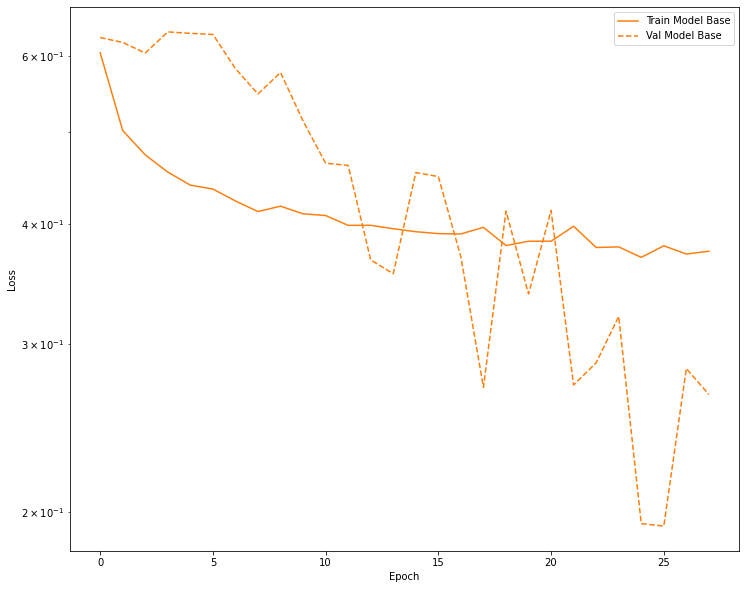

In [39]:
plot_loss(history, "Model Base", 1)

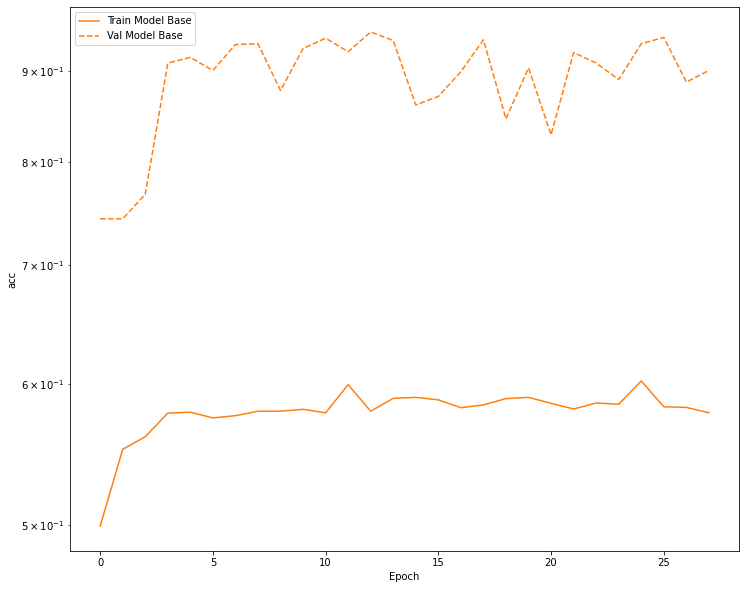

In [40]:
plot_acc(history, "Model Base", 1)

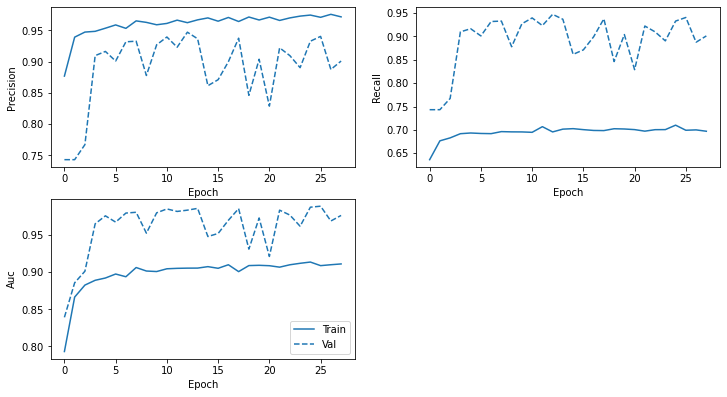

In [41]:
plot_metrics(history)

In [42]:
Y_validation_proba = model.predict(validation_generator, steps = VALIDATION_STEPS_PER_EPOCH)  

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

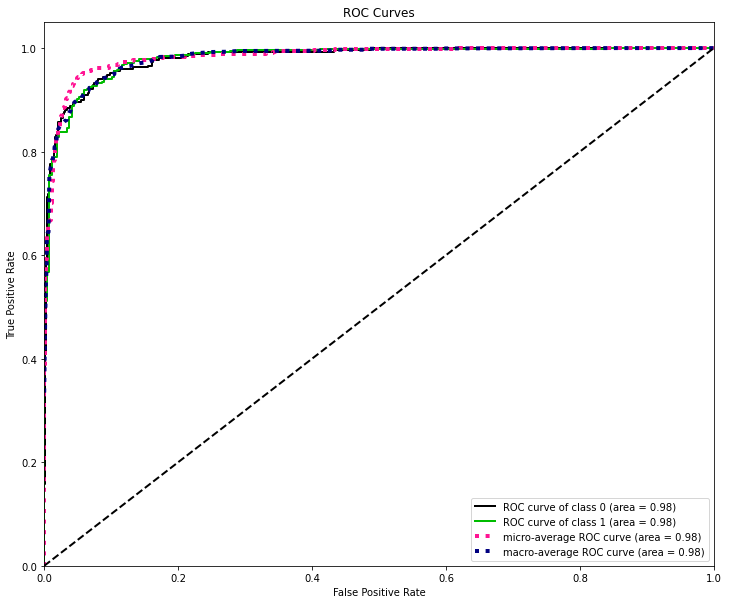

In [43]:
skplt.metrics.plot_roc(validation_generator.classes, Y_validation_proba)

In [44]:
# skplt.metrics.plot_ks_statistic(validation_generator.classes, Y_validation_proba)

In [45]:
Y_validation_pred = (Y_validation_proba[:,1] > 0.5)*1

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

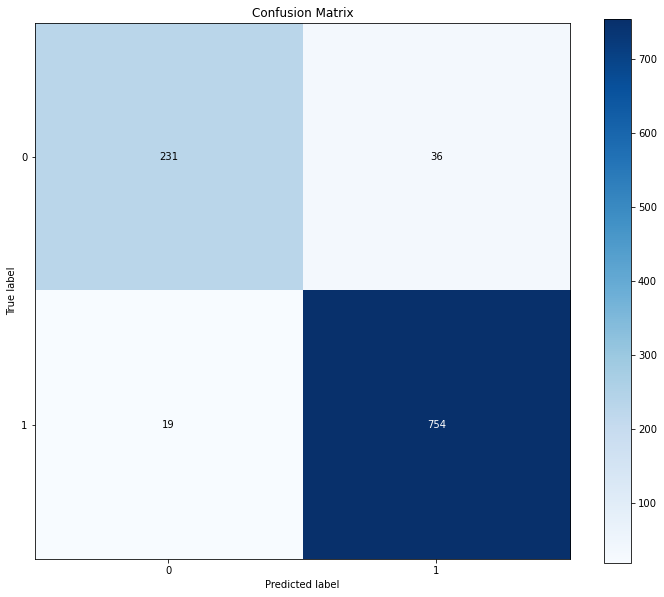

In [46]:
skplt.metrics.plot_confusion_matrix(validation_generator.classes, Y_validation_pred, normalize=False)

In [47]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(validation_generator.classes, Y_validation_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      normal       0.92      0.87      0.89       267
     opacity       0.95      0.98      0.96       773

    accuracy                           0.95      1040
   macro avg       0.94      0.92      0.93      1040
weighted avg       0.95      0.95      0.95      1040



In [48]:
Y_test_proba = model.predict(test_generator, steps = TEST_STEPS_PER_EPOCH)  

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

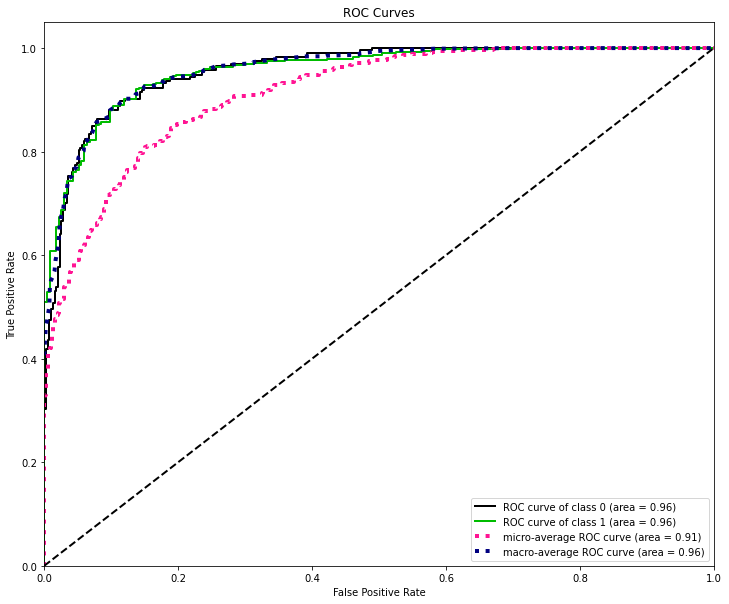

In [49]:
skplt.metrics.plot_roc(test_generator.classes, Y_test_proba)

In [50]:
#skplt.metrics.plot_ks_statistic(test_generator.classes, Y_test_proba)

In [51]:
Y_test_pred = (Y_test_proba[:,1] > 0.5)*1

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

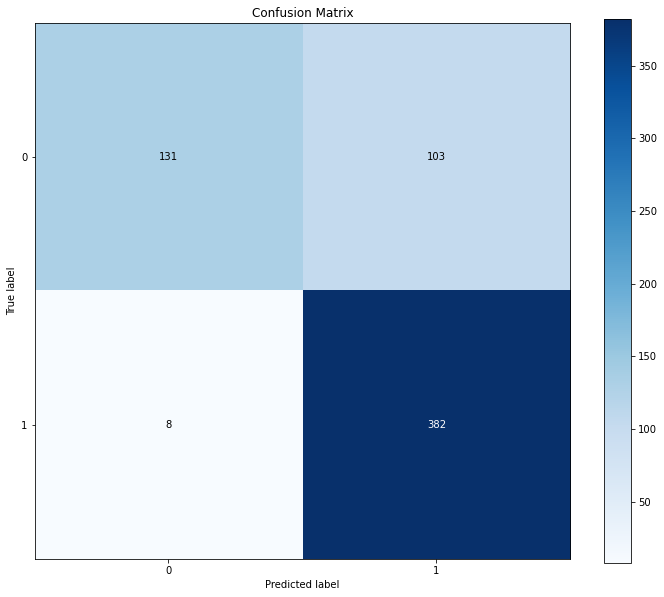

In [52]:
skplt.metrics.plot_confusion_matrix(test_generator.classes, Y_test_pred, normalize=False)

In [53]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(test_generator.classes, Y_test_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      normal       0.94      0.56      0.70       234
     opacity       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



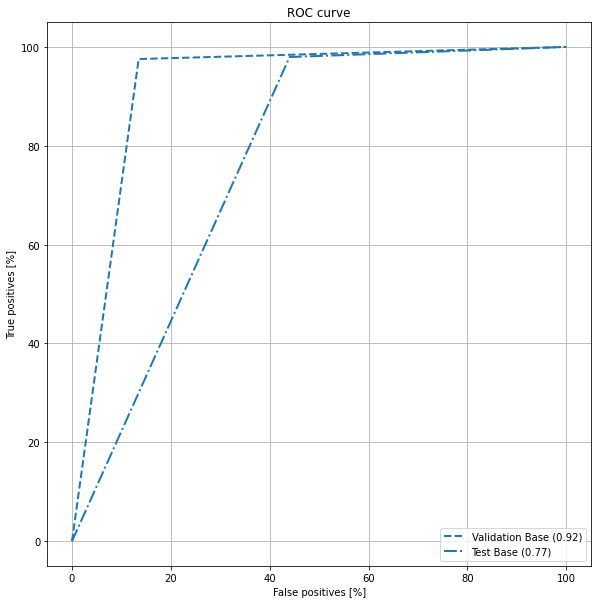

In [54]:
plot_roc("Validation Base", validation_generator.classes, Y_validation_pred, color=colors[0], linestyle='--')
plot_roc("Test Base", test_generator.classes, Y_test_pred, color=colors[0], linestyle='-.')

plt.legend(loc='lower right')

# Class Weights

In [55]:
from collections import Counter
itemCt = Counter(train_generator_1.classes)
sumCt = float(sum(itemCt.values()))
cw = {clsID : numImg/sumCt for clsID, numImg in itemCt.items()}
cw

{0: 0.25811068702290074, 1: 0.7418893129770993}

In [56]:
model_cw = our_model([32, 16], INPUT_SHAPE)

In [57]:
model_cw.compile(loss = 'categorical_crossentropy',  
              optimizer=Adam(lr = 1e-4, amsgrad = True),
              metrics=METRICS)

In [ ]:
start = timeit.default_timer()

history_cw = model_cw.fit(
      train_generator_1,  
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH,    
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  
      shuffle= False,   
      callbacks = CALLBACKS,
      verbose = 1,
      class_weight = cw 
)

stop = timeit.default_timer()

print('Time: ', (stop - start)/60)

model.save('model_base_cw')

Epoch 1/100
33/33 [==============================] - 96s 3s/step - loss: 0.3632 - fn: 781.7941 - accuracy: 0.7669 - precision: 0.7669 - recall: 0.7669 - auc: 0.8365 - val_loss: 0.6158 - val_fn: 267.0000 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 0.7433 - val_auc: 0.7867
Epoch 2/100
33/33 [==============================] - 80s 2s/step - loss: 0.1768 - fn: 479.5588 - accuracy: 0.7799 - precision: 0.7799 - recall: 0.7799 - auc: 0.8838 - val_loss: 0.5863 - val_fn: 267.0000 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 0.7433 - val_auc: 0.8554
Epoch 3/100
33/33 [==============================] - 79s 2s/step - loss: 0.1503 - fn: 387.4412 - accuracy: 0.8184 - precision: 0.8184 - recall: 0.8184 - auc: 0.9183 - val_loss: 0.5584 - val_fn: 263.0000 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 0.7471 - val_auc: 0.8930
Epoch 4/100
33/33 [==============================] - 78s 2s/step - loss: 0.1259 - fn: 304.8235 - accuracy: 0.8614 - precision: 0.8614

In [ ]:
model_cw.save("model_cw")

In [ ]:
plot_loss(history_cw, "Model Base", 1)

In [ ]:
plot_acc(history_cw, "Model cw", 1)

In [ ]:
plot_metrics(history_cw)

In [ ]:
Y_validation_proba_cw = model_cw.predict(validation_generator, steps = VALIDATION_STEPS_PER_EPOCH)  

In [ ]:
skplt.metrics.plot_roc(validation_generator.classes, Y_validation_proba_cw)

In [ ]:
skplt.metrics.plot_ks_statistic(validation_generator.classes, Y_validation_proba_cw)

In [ ]:
Y_validation_pred_cw = (Y_validation_proba_cw[:,1] > 0.5)*1

In [ ]:
skplt.metrics.plot_confusion_matrix(validation_generator.classes, Y_validation_pred_cw, normalize=False)

In [ ]:
print('Confusion Matrix')
cm_validation_cw = confusion_matrix(validation_generator.classes, Y_validation_pred_cw, labels = [0,1])
print(cm_validation_cw)

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(validation_generator.classes, Y_validation_pred_cw, target_names=target_names))

In [ ]:
Y_test_proba_cw = model_cw.predict(test_generator, steps = TEST_STEPS_PER_EPOCH)

In [ ]:
skplt.metrics.plot_roc(test_generator.classes, Y_test_proba_cw)

In [ ]:
skplt.metrics.plot_ks_statistic(test_generator.classes, Y_test_proba_cw)

In [ ]:
Y_test_pred_cw = (Y_test_proba_cw[:,1] > 0.5)*1

In [ ]:
skplt.metrics.plot_confusion_matrix(test_generator.classes, Y_test_pred_cw, normalize=False)

In [ ]:
print('Confusion Matrix')
cm_test_cw = confusion_matrix(test_generator.classes, Y_test_pred_cw, labels = [0,1])
print(cm_test_cw)

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(test_generator.classes, Y_test_pred_cw, target_names=target_names))

In [ ]:
plot_roc("Validation Base", validation_generator.classes, Y_validation_pred_cw, color=colors[0], linestyle='--')
plot_roc("Test Base", test_generator.classes, Y_test_pred_cw, color=colors[0], linestyle='-.')
plt.legend(loc='lower right')

# Focal Loss

https://github.com/umbertogriffo/focal-loss-keras

In [ ]:
!pip install focal-loss

In [ ]:
from focal_loss import BinaryFocalLoss

In [ ]:
model_fl = our_model([32, 16], INPUT_SHAPE)

In [ ]:
from keras import backend as K

# def focal_loss(gamma=2., alpha=.25):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#         return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
#     return focal_loss_fixed

In [ ]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
model_fl.compile(loss=focal_loss(gamma=1.5,alpha=0.25), optimizer=Adam(lr=1e-4), metrics=METRICS)

In [ ]:
start = timeit.default_timer()

history_fl = model_fl.fit(
      train_generator_1,  
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH, #train_generator.get_steps_per_epoch(),
      #TRAIN_STEPS_PER_EPOCH,    
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  
      shuffle= False,   
      callbacks = CALLBACKS,
      verbose = 1,
)

stop = timeit.default_timer()

print('Time: ', (stop - start)/60)

model.save('model_base_fl')

In [ ]:
model.save("model_fl")

In [ ]:
plot_loss(history_fl, "Model_fl", 1)

In [ ]:
plot_acc(history_fl, "Model fl", 1)

In [ ]:
plot_metrics(history_fl)

In [ ]:
Y_validation_proba_fl = model_fl.predict(validation_generator, steps = VALIDATION_STEPS_PER_EPOCH)

In [ ]:
skplt.metrics.plot_roc(validation_generator.classes, Y_validation_proba_fl)

In [ ]:
skplt.metrics.plot_ks_statistic(validation_generator.classes, Y_validation_proba_fl)

In [ ]:
Y_validation_pred_fl = (Y_validation_proba_fl[:,1] > 0.5)*1

In [ ]:
skplt.metrics.plot_confusion_matrix(validation_generator.classes, Y_validation_pred_fl, normalize=True)

In [ ]:
print('Confusion Matrix')
cm_validation_fl = confusion_matrix(validation_generator.classes, Y_validation_pred_fl, labels = [0,1])
print(cm_validation_fl)

In [ ]:
Y_test_proba_fl = model_fl.predict(test_generator, steps = TEST_STEPS_PER_EPOCH)  

In [ ]:
skplt.metrics.plot_roc(test_generator.classes, Y_test_proba_fl)

In [ ]:
skplt.metrics.plot_ks_statistic(test_generator.classes, Y_test_proba_fl)

In [ ]:
Y_test_pred_fl = (Y_test_proba_fl[:,1] > 0.5)*1

In [ ]:
skplt.metrics.plot_confusion_matrix(test_generator.classes, Y_test_pred_fl, normalize=False)

In [ ]:
print('Confusion Matrix')
cm_test_fl = confusion_matrix(test_generator.classes, Y_test_pred_fl, labels = [0,1])
print(cm_test_fl)

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(test_generator.classes, Y_test_pred_fl, target_names=target_names))

In [ ]:
plot_roc("Validation Base", validation_generator.classes, Y_validation_pred_fl, color=colors[0], linestyle='--')
plot_roc("Test Base", test_generator.classes, Y_test_pred_fl, color=colors[0], linestyle='-.')


plt.legend(loc='lower right')

# Transfert Learning with focal loss function

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
x = np.array([[4,2,3], 
              [1,0,3]])
index_array = np.argmax(x, axis=-1)

In [ ]:
vgg16_model =  VGG16(input_shape = (64,64,3), weights='imagenet', include_top=False)

In [ ]:
vgg16_model.summary()

In [ ]:
# don't train existing weights
for layer in vgg16_model.layers:
    layer.trainable = False    

In [ ]:
model_tf = Sequential()
model_tf.add(vgg16_model)
model_tf.add(GlobalAveragePooling2D())
model_tf.add(BatchNormalization())
model_tf.add(Dense(128, activation='relu'))
#model_tf.add(Dropout(0.5))
model_tf.add(BatchNormalization())
model_tf.add(Dense(64, activation='relu'))
model_tf.add(Dropout(0.5))
model_tf.add(Dense(2, activation='softmax'))

model_tf.summary()

In [ ]:
model_tf.compile(loss='categorical_crossentropy',optimizer=Adam(lr=1e-4),metrics=METRICS)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   vertical_flip = False,
                                   horizontal_flip = False,
                                   rotation_range = 15,
                                   brightness_range = [0.9, 1.1],
                                   zoom_range = 0.2                                  
                                   )

train_generator_tf = train_datagen.flow_from_directory(
        directory = train_directory,  
        target_size = TARGET_SIZE,   
        batch_size = BATCH_SIZE,        
        color_mode='rgb',
        class_mode= CLASS_MODE,    
        shuffle = True,   
        seed = 142,
        )

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator_tf = validation_datagen.flow_from_directory(
        directory = validation_directory,
        target_size = TARGET_SIZE,
        batch_size = BATCH_SIZE,
        color_mode ='rgb',
        class_mode= CLASS_MODE,    
        shuffle = True, 
        )

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_tf = test_datagen.flow_from_directory(
        directory = test_directory,
        target_size = TARGET_SIZE,
        batch_size = BATCH_SIZE,
        color_mode ='rgb',
        class_mode = None,    
        shuffle = False,
        )

In [ ]:
start = timeit.default_timer()

history_tf = model_tf.fit(
      train_generator_tf,  
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH,    
      epochs = EPOCHS,
      validation_data = validation_generator_tf,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  
      shuffle= False,   
      callbacks = CALLBACKS,
      verbose = 1, 
)

stop = timeit.default_timer()

print('Time: ', (stop - start)/60)

model.save('model_base_tf')

In [ ]:
plot_loss(history_tf, "Model_tf", 1)

In [ ]:
plot_metrics(history_tf)

In [ ]:
Y_train_proba_tf = model_tf.predict(train_generator_tf, steps = TRAIN_STEPS_PER_EPOCH)  

In [ ]:
skplt.metrics.plot_roc(train_generator.classes, Y_train_proba_tf)

In [ ]:
skplt.metrics.plot_ks_statistic(train_generator.classes, Y_train_proba_tf)

In [ ]:
Y_train_pred_tf = (Y_train_proba_tf[:,1] > 0.537)*1

In [ ]:
skplt.metrics.plot_confusion_matrix(train_generator.classes, Y_train_pred_tf, normalize=True)

In [ ]:
print('Confusion Matrix')
cm_train_tf = confusion_matrix(train_generator_tf.classes, Y_train_pred_tf, labels = [0,1])
print(cm_train_tf)

In [ ]:
Y_validation_proba_tf = model_tf.predict(validation_generator_tf, steps = VALIDATION_STEPS_PER_EPOCH)

In [ ]:
skplt.metrics.plot_roc(validation_generator.classes, Y_validation_proba_tf)

In [ ]:
skplt.metrics.plot_ks_statistic(validation_generator.classes, Y_validation_proba_tf)

In [ ]:
Y_validation_pred_tf = (Y_validation_proba_tf[:,1] > 0.537)*1

In [ ]:
skplt.metrics.plot_confusion_matrix(validation_generator.classes, Y_validation_pred_tf, normalize=True)

In [ ]:
print('Confusion Matrix')
cm_validation_tf = confusion_matrix(validation_generator_tf.classes, Y_validation_pred_tf, labels = [0,1])
print(cm_validation_tf)

In [ ]:
Y_test_proba_tf = model_tf.predict(test_generator_tf, steps = TEST_STEPS_PER_EPOCH)  

In [ ]:
skplt.metrics.plot_roc(test_generator.classes, Y_test_proba_tf)

In [ ]:
skplt.metrics.plot_ks_statistic(test_generator.classes, Y_test_proba_tf)

In [ ]:
Y_test_pred_tf = (Y_test_proba_tf[:,1] > 0.5)*1

In [ ]:
skplt.metrics.plot_confusion_matrix(test_generator.classes, Y_test_pred_tf, normalize=False)

In [ ]:
print('Confusion Matrix')
cm_test_tf = confusion_matrix(test_generator_tf.classes, Y_test_pred_tf, labels = [0,1])
print(cm_test_tf)

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(test_generator_tf.classes, Y_test_pred_tf, target_names=target_names))

In [ ]:
plot_roc("Validation Base", validation_generator_tf.classes, Y_validation_pred_tf, color=colors[0], linestyle='--')
plot_roc("Test Base", test_generator_tf.classes, Y_test_pred_tf, color=colors[0], linestyle='-.')


plt.legend(loc='lower right')

# Fine tuning the parameters

In [ ]:
model_fine_tuning = model_tf
#unfreeze final convolution blocks
model_tf.trainable = True
set_trainable = False
for layer in model_tf.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        


In [ ]:
# x = Flatten()(vgg16_model.output)
# x = Dense(units=128, activation='relu')(x)
# x = Dense(units=64, activation='relu')(x)
# prediction = Dense(1, kernel_initializer=GlorotNormal(), activation='sigmoid')(x)

In [ ]:
# model_fine_tuning = Model(inputs=vgg16_model.input, outputs=prediction)

In [ ]:
model_fine_tuning.compile(loss= 'categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=METRICS)

In [ ]:
start = timeit.default_timer()

history_fine_tuning = model_fine_tuning.fit(
      train_generator_tf,  
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH,    
      epochs = EPOCHS,
      validation_data = validation_generator_tf,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  
      shuffle= False,   
      callbacks = CALLBACKS,
      verbose = 1, 
)

stop = timeit.default_timer()

print('Time: ', (stop - start)/60)

In [ ]:
model.save('model_base_fine_tuned')

In [ ]:
Y_validation_proba_fine_tuning = model_fine_tuning.predict(validation_generator_tf, steps = VALIDATION_STEPS_PER_EPOCH)

In [ ]:
skplt.metrics.plot_roc(validation_generator_tf.classes, Y_validation_proba_fine_tuning)

In [ ]:
skplt.metrics.plot_ks_statistic(validation_generator_tf.classes, Y_validation_proba_fine_tuning)

In [ ]:
Y_validation_pred_fine_tuning = (Y_validation_proba_fine_tuning[:,1] > 0.5)*1

In [ ]:
skplt.metrics.plot_confusion_matrix(validation_generator_tf.classes, Y_validation_pred_fine_tuning, normalize=False)

In [ ]:
print('Confusion Matrix')
cm_validation_tf = confusion_matrix(validation_generator_tf.classes, Y_validation_pred_fine_tuning, labels = [0,1])
print(cm_validation_tf)

In [ ]:
Y_test_proba_fine_tuning = model_fine_tuning.predict(test_generator_tf, steps = TEST_STEPS_PER_EPOCH)  

In [ ]:
skplt.metrics.plot_roc(test_generator_tf.classes, Y_test_proba_fine_tuning)

In [ ]:
skplt.metrics.plot_ks_statistic(test_generator_tf.classes, Y_test_proba_fine_tuning)

In [ ]:
Y_test_pred_fine_tuning = (Y_test_proba_fine_tuning[:,1] > 0.5)*1

In [ ]:
skplt.metrics.plot_confusion_matrix(test_generator_tf.classes, Y_test_pred_fine_tuning, normalize=False)

In [ ]:
print('Confusion Matrix')
cm_test_tf = confusion_matrix(test_generator_tf.classes, Y_test_pred_fine_tuning, labels = [0,1])
print(cm_test_tf)

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(test_generator_tf.classes, Y_test_pred_fine_tuning, target_names=target_names))

# Hyperparameter tuning with Keras Tuner

In [ ]:
# import tensorflow as tf

# def build_model(hp):
#     inputs = tf.keras.Input(shape= (32, 32, 1))#(32, 32, 3))
#     x = inputs
#     for i in range(hp.Int('conv_blocks', 1, 2, default=2)):
#         filters = hp.Int('filters_' + str(i), 32, 256, step=32)
#         for _ in range(2):
#             x = tf.keras.layers.Convolution2D(filters, kernel_size=(3, 3), padding='same')(x)
#             x = tf.keras.layers.BatchNormalization()(x)
#             x = tf.keras.layers.ReLU()(x)
#         if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
#             x = tf.keras.layers.MaxPool2D()(x)
#         else:
#             x = tf.keras.layers.AvgPool2D()(x)
  
#     x = tf.keras.layers.GlobalAvgPool2D()(x)
#     x = tf.keras.layers.Dense(hp.Int('hidden_size', 30, 100, step=10, default=50),activation='relu')(x)
#     x = tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
#     outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

#     model = tf.keras.Model(inputs, outputs)
#     model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
#                 loss='binary_crossentropy', 
#                 metrics= METRICS) #['accuracy'])
#     return model

In [ ]:
def get_model_design_hp(hp):
    model = Sequential([Conv2D(hp.Int('filters_0',16,32,step=8,default=32),kernel_size=(5,5),padding='same',kernel_regularizer=l2(0.001),activation='relu',input_shape=INPUT_SHAPE),
                        Conv2D(hp.Int('filters_1',16,32,step=8,default=16),kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001),activation='relu'),
                        MaxPool2D(pool_size=(2,2)),
                        BatchNormalization(),
                        Flatten(),
                        Dropout(hp.Float('dropout',0,0.5,step=0.25,default=0.5)),
                        Dense(units = hp.Int('Dense',32,64,step=8,default=64),activation='relu'),
                        Dropout(0.2),
                        Dense(1, kernel_initializer=GlorotNormal(), activation='sigmoid')
                       ])
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                loss='binary_crossentropy',metrics= METRICS) 
    
    return model

In [ ]:
list(range(4))

In [ ]:
import time
LOG_DIR = f'{int(time.time())}'

In [ ]:
import kerastuner as kt

tuner = kt.Hyperband(
    get_model_design_hp,
    objective= 'val_loss' ,#'val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory = LOG_DIR    
)

In [ ]:
tuner.search(train_generator,
             validation_data = validation_generator,
             epochs=2,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [ ]:
best_model = tuner.get_best_models(1)[0]

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
# # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# model = tuner.hypermodel.build(best_hyperparameters)
# history = model.fit(img_train, 
#                     label_train, 
#                     epochs=50,
#                     validation_split=0.2)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

In [ ]:
# hypermodel = tuner.hypermodel.build(best_hyperparameters)

# # Retrain the model
# hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

In [ ]:
KHASK TST3ml le meme model bach t3awd lhypertunning

In [ ]:
# def get_model_design_hp(filters, input_shape):
#     model = Sequential([Conv2D(filters[0], (5, 5),  padding='same', kernel_regularizer=l2(0.001), activation='relu', input_shape=input_shape),
#                         Conv2D(filters[1], (3, 3),  padding='same', kernel_regularizer=l2(0.001), activation='relu'),
#                         MaxPool2D(pool_size=(2, 2)),
#                         BatchNormalization(),
#                         Flatten(),
#                         Dropout(0.5),
#                         Dense(1, kernel_initializer=GlorotNormal(), activation='sigmoid')
#                        ])
#     return model

In [ ]:
# def model_builder(hp):
#   model = keras.Sequential()
#   model.add(keras.layers.Flatten(input_shape=(28, 28)))

#   # Tune the number of units in the first Dense layer
#   # Choose an optimal value between 32-512
#   hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#   model.add(keras.layers.Dense(units=hp_units, activation='relu'))
#   model.add(keras.layers.Dense(10))

#   # Tune the learning rate for the optimizer
#   # Choose an optimal value from 0.01, 0.001, or 0.0001
#   hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#   model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])

#   return model

In [ ]:
classifier = CNN_model(optimizer='sgd', dropout=0.5, init='uniform', units = UNITS_DENSE)

In [ ]:
classifier.summary()

In [ ]:
plot_model(classifier, to_file='model_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
#rmsprop = RMSprop()
# adam = Adam()
# adadelta = Adadelta()
# adagrad = Adagrad()
# adamax = Adamax()
# nadam = Nadam()
# ftrl = Ftrl()

In [ ]:
# classifier.compile(optimizer = RMSprop(lr=0.001), loss = 'SparseCategoricalCrossentropy', metrics = ['acc'])

In [ ]:
CALLBACKS = [
            #EarlyStopping(monitor='val_loss', min_delta=0, patience = 4, verbose=1, mode='auto', restore_best_weights = True),
            TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True),
            #ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=1, min_lr=0.000001, min_delta = 0.1, verbose=1)
            ]

In [ ]:
TRAIN_STEPS_PER_EPOCH = np.math.ceil(train_generator.samples/train_generator.batch_size)
VALIDATION_STEPS_PER_EPOCH = np.math.ceil(validation_generator.samples/validation_generator.batch_size)

In [ ]:
start = timeit.default_timer()

#steps_per_epoch_train = train_generator.samples//train_generator.batch_size

history = classifier.fit(
      train_generator,  ##directory =
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH,    # images = batch_size * steps
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  # images = batch_size * steps
      shuffle= False,   #False,
      callbacks = CALLBACKS,
      verbose = 1,
      class_weight = cw
      )


stop = timeit.default_timer()

print('Time: ', (stop - start)/60)

In [ ]:
Y_pred = classifier.predict(validation_generator, steps = VALIDATION_STEPS_PER_EPOCH)  
Y_pred[Y_pred <= 0.5] = 0
Y_pred[Y_pred > 0.5] = 1

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, Y_pred)
print(cm)

In [ ]:
cm_pd = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (6,5))
sns.heatmap(cm_pd,cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',
            xticklabels = ['Predicted Normal', 'Predicted Pneumonia'],
            yticklabels = ['Actual Normal', 'Actual Pneumonia'])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(validation_generator.classes, Y_pred, target_names=target_names))

In [ ]:
cm = pd.DataFrame(data = cm, index = ["Actual Normal", "Actual Pneumonia"], columns = ["Predicted Normal", "Predicted Pneumonia"])
cm

We verifie our results on the test set.

In [ ]:
TEST_STEPS_PER_EPOCH = np.math.ceil(test_generator.samples / test_generator.batch_size)
print(TEST_STEPS_PER_EPOCH)

In [ ]:
Y_pred = classifier.predict(test_generator, steps = TEST_STEPS_PER_EPOCH)  
Y_pred[Y_pred <= 0.5] = 0
Y_pred[Y_pred > 0.5] = 1

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, Y_pred, labels = [0,1])
print(cm)

In [ ]:
cm_pd = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (6,5))
sns.heatmap(cm_pd,cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',
            xticklabels = ['Predicted Normal', 'Predicted Pneumonia'],
            yticklabels = ['Actual Normal', 'Actual Pneumonia'])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(test_generator.classes, Y_pred, target_names=target_names))

In [ ]:
cm = pd.DataFrame(data = cm, index = ["Actual Normal", "Actual Pneumonia"], columns = ["Predicted Normal", "Predicted Pneumonia"])
cm

In [ ]:
test_score = classifier.evaluate(test_generator, steps = TEST_STEPS_PER_EPOCH)

print('accuracy: {:.2f}%'.format(test_score[1]*100))
print('Loss:', test_score[0])
print(test_score)

The thing is, precision and recall are highly used for imbalanced dataset because in an highly imbalanced dataset, a 99% accuracy can be meaningless.

In [ ]:
classifier.save_weights('first_try.h5')

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['acc']
validation_loss = history.history['val_loss']
validation_acc = history.history['val_acc']

In [ ]:
plt.plot(train_loss, linewidth = 3.0)
plt.plot(validation_loss, linewidth = 3.0)
plt.legend(['training Loss','Validation Loss'], fontsize = 18)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Loss Curves', fontsize = 16)

In [ ]:
METRICS = [
           metrics.TruePositives(name = 'tp'),
           metrics.FalsePositives(name = 'fp'),
           metrics.TrueNegatives(name = 'tn'),
           metrics.FalseNegatives(name = 'fn'),
           metrics.BinaryAccuracy(name = 'accuracy'),
           metrics.Precision(name = 'precision'),
           metrics.Recall(name = 'recall'),
           metrics.AUC(name = 'auc'),


]

In [ ]:
from keras import initializers

In [ ]:
BIAS_INITIALIZER = np.log((3110 + 773)/(1082 + 267))
BIAS_INITIALIZER

In [ ]:
def CNN_model(optimizer='RMSprop',dropout=0.5,init='uniform',input_shape= INPUT_SHAPE, units = UNITS_DENSE, output_bias = BIAS_INITIALIZER):
       #dense_nparams, activation='relu', input_shape=(nbr_features,), kernel_initializer=init,
       model = Sequential([  
       Conv2D(FEATURES_MAP, (3,3), activation='relu',input_shape= INPUT_SHAPE, kernel_initializer=init,),
       MaxPooling2D(pool_size = (2,2)),
       #Dropout(dropout),
       Conv2D(FEATURES_MAP, (3,3), activation='relu'),
       MaxPooling2D(pool_size = (2,2)),
       #Dropout(dropout),
       Conv2D(2*FEATURES_MAP, (3,3), activation='relu'), 
       MaxPooling2D(pool_size = (2,2)),
       #Dropout(dropout),
       # Flatten the results to feed into a DNN
       Flatten(), 
       Dense(units = UNITS_DENSE, activation='relu'), 
       Dense(units = 1, activation = 'sigmoid', bias_initializer = initializers.Constant(output_bias))])
       model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['acc'])
       return model

In [ ]:
classifier = CNN_model(optimizer='adam', dropout=0.5, init='uniform', units = UNITS_DENSE, output_bias = BIAS_INITIALIZER)

In [ ]:
CALLBACKS = [
            ##EarlyStopping(monitor='acc', min_delta=0, patience=2, verbose=2, mode='auto', restore_best_weights = True),
             ##val_loss
            TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]  

In [ ]:
TRAIN_STEPS_PER_EPOCH = np.math.ceil(train_generator.samples/train_generator.batch_size)
VALIDATION_STEPS_PER_EPOCH = np.math.ceil(validation_generator.samples/validation_generator.batch_size)

In [ ]:
import timeit

start = timeit.default_timer()

#steps_per_epoch_train = train_generator.samples//train_generator.batch_size

history = classifier.fit(
      train_generator,  ##directory =
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH,    # images = batch_size * steps
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  # images = batch_size * steps
      shuffle= False,   #False,
      callbacks = CALLBACKS,
      verbose = 1
      )


stop = timeit.default_timer()

print('Time: ', (stop - start)/60)

In [ ]:
Y_pred = classifier.predict(validation_generator, steps = VALIDATION_STEPS_PER_EPOCH)  # ceil(num_of_test_samples / batch_size)
Y_pred[Y_pred <= 0.5] = 0
Y_pred[Y_pred > 0.5] = 1

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, Y_pred)
print(cm)

In [ ]:
cm_pd = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (6,5))
sns.heatmap(cm_pd,cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',
            xticklabels = ['Predicted Normal', 'Predicted Pneumonia'],
            yticklabels = ['Actual Normal', 'Actual Pneumonia'])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(validation_generator.classes, Y_pred, target_names=target_names))

In [ ]:
cm = pd.DataFrame(data = cm, index = ["Actual Normal", "Actual Pneumonia"], columns = ["Predicted Normal", "Predicted Pneumonia"])
cm

In [ ]:
STEPS_PER_EPOCH_TEST = np.math.ceil(test_generator.samples / test_generator.batch_size)
print(STEPS_PER_EPOCH_TEST)

In [ ]:
Y_pred = classifier.predict(test_generator, steps = STEPS_PER_EPOCH_TEST)  # ceil(num_of_test_samples / batch_size)
Y_pred[Y_pred <= 0.5] = 0
Y_pred[Y_pred > 0.5] = 1

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, Y_pred, labels = [0,1])
print(cm)

In [ ]:
cm_pd = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (6,5))
sns.heatmap(cm_pd,cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',
            xticklabels = ['Predicted Normal', 'Predicted Pneumonia'],
            yticklabels = ['Actual Normal', 'Actual Pneumonia'])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(test_generator.classes, Y_pred, target_names=target_names))

In [ ]:
cm = pd.DataFrame(data = cm, index = ["Actual Normal", "Actual Pneumonia"], columns = ["Predicted Normal", "Predicted Pneumonia"])
cm

In [ ]:
test_score = classifier.evaluate(test_generator, steps = STEPS_PER_EPOCH_TEST)

print('accuracy: {:.2f}%'.format(test_score[1]*100))
print('Loss:', test_score[0])

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [ ]:
import os
import tempfile

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
classifier.save_weights(initial_weights)

Cofirm that the bias fix helps:
Before moving on, confirm quick that the careful bias initialization actually helped.
Train the model for EPOCHS epochs, with and without this careful initialization, and compare the losses

In [ ]:
model = CNN_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
      train_generator,  ##directory =
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH,    # images = batch_size * steps
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  # images = batch_size * steps
      shuffle= False,   #False,
      verbose = 1   
      )

In [ ]:
model = CNN_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
      train_generator,  ##directory =
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH,    # images = batch_size * steps
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  # images = batch_size * steps
      shuffle= False,   #False,
      verbose = 1   
      )

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color = colors[n], label='Train'+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color = colors[n], label = 'Val'+label, linestyle='--')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [ ]:
plot_loss(zero_bias_history, 'Zero Bias', 0)
plot_loss(careful_bias_history, 'Careful Bias', 1)

Train The model

In [ ]:
model = CNN_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
      train_generator,  ##directory =
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH,    # images = batch_size * steps
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  # images = batch_size * steps
      shuffle = False,   #False,
      callbacks = CALLBACKS,
      verbose = 1   
      )

In this section, we will produce plos of our model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this tutorial.
Additionaly, you can produce these plots for any of the metrics you created above. False negtives are included as an example. 

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace('_', ' ').capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color = colors[0], label = 'Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle='--', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

In [ ]:
plot_metrics(baseline_history)

Evaluate Metrics 

Transfert Learniiiing

The typical transfer-learning workflow

In [ ]:
EPOCHS = 20
SEED = 42

WIDTH = 224 #150
HEIGHT = 224 #150 
DEPTH = 1
DEPTH_RGB = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)
INPUT_SHAPE_RGB = (WIDTH, HEIGHT, DEPTH_RGB)
TARGET_SIZE = (WIDTH , HEIGHT)
BATCH_SIZE = 100     
COLOR_MODE = 'grayscale'
COLOR_MODE_RGB = 'rgb'
CLASS_MODE = 'binary'
UNITS_DENSE = 64
FEATURES_MAP = 32

In [ ]:
base_model = MobileNet(weights = 'imagenet', # Load weights pre-trained on ImageNet.
                       input_shape = INPUT_SHAPE_RGB,   #(WIDTH, HEIGHT, DEPTH_RGB),
                       include_top = False
                       )

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
preds = Dense(1, activation = 'sigmoid')(x)

In [ ]:
base_model.trainable = False

In [ ]:
#inputs = Input(shape = (WIDTH, HEIGHT, DEPTH_RGB))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
model = Model(inputs = base_model.input, outputs =preds) ##inputs,

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',#'binary_crossentropy', BinaryCrossentropy(from_logits=True)
              metrics = ['acc']
              )

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   #shear_range = ,
                                   #zoom_range = ,
                                   vertical_flip = True,
                                   #horizontal_flip = True,
                                   )


# Flow training images in batches of xx using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        directory = train_directory,  # This is the source directory for training images
        target_size = TARGET_SIZE,  # All images will be resized to 150x150 
        batch_size = BATCH_SIZE,        
        color_mode = COLOR_MODE_RGB,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode= CLASS_MODE,    
        shuffle = False,
        seed = 442,
        )

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow validation images in batches of xx using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        directory = validation_directory,
        target_size = TARGET_SIZE,
        batch_size = BATCH_SIZE,
        color_mode = COLOR_MODE_RGB,
        class_mode= CLASS_MODE,    
        shuffle = False,
        seed = 442,
        )

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow validation images in batches of xx using validation_datagen generator
test_generator = test_datagen.flow_from_directory(
        directory = test_directory,
        target_size = TARGET_SIZE,
        batch_size = BATCH_SIZE,
        color_mode = COLOR_MODE_RGB,
        class_mode = None,    ##CLASS_MODE le test galik makandirouhch
        shuffle = False,
        seed = 442,
        )

In [ ]:
import timeit
start = timeit.default_timer()

history = model.fit(
      train_generator,  ##directory =
      steps_per_epoch = TRAIN_STEPS_PER_EPOCH,    # images = batch_size * steps
      epochs = EPOCHS,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS_PER_EPOCH,  # images = batch_size * steps
      shuffle= False,   #False,
      callbacks = CALLBACKS,
      verbose = 1
      )


stop = timeit.default_timer()

print('Time: ', (stop - start)/60)

In [ ]:
Y_pred = model.predict(validation_generator, steps = VALIDATION_STEPS_PER_EPOCH)  # ceil(num_of_test_samples / batch_size)
Y_pred[Y_pred <= 0.5] = 0
Y_pred[Y_pred > 0.5] = 1

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, Y_pred)
print(cm)

In [ ]:
cm_pd = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (6,5))
sns.heatmap(cm_pd,cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',
            xticklabels = ['Predicted Normal', 'Predicted Pneumonia'],
            yticklabels = ['Actual Normal', 'Actual Pneumonia'])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(validation_generator.classes, Y_pred, target_names=target_names))

In [ ]:
cm = pd.DataFrame(data = cm, index = ["Actual Normal", "Actual Pneumonia"], columns = ["Predicted Normal", "Predicted Pneumonia"])
cm

TEST

In [ ]:
STEPS_PER_EPOCH_TEST = np.math.ceil(test_generator.samples / test_generator.batch_size)

In [ ]:
Y_pred = model.predict(test_generator, steps = STEPS_PER_EPOCH_TEST)  # ceil(num_of_test_samples / batch_size)
Y_pred[Y_pred <= 0.5] = 0
Y_pred[Y_pred > 0.5] = 1

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, Y_pred, labels = [0,1])
print(cm)

In [ ]:
cm_pd = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (6,5))
sns.heatmap(cm_pd,cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='',
            xticklabels = ['Predicted Normal', 'Predicted Pneumonia'],
            yticklabels = ['Actual Normal', 'Actual Pneumonia'])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print('Classification Report')
target_names = ['normal', 'opacity'] 
print(classification_report(test_generator.classes, Y_pred, target_names=target_names))

In [ ]:
cm = pd.DataFrame(data = cm, index = ["Actual Normal", "Actual Pneumonia"], columns = ["Predicted Normal", "Predicted Pneumonia"])
cm

In [ ]:
test_score = model.evaluate(test_generator, steps =1000)
## batch_size = BATCH_SIZE
##steps = STEPS_PER_EPOCH_TEST
test_score
#print('accuracy: {:.2f}%'.format(test_score[1]*100))
#print('Loss:', test_score[0])

In [ ]:
!pip install scikit-optimize

In [ ]:
#imports we know we'll need
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

In [ ]:
DIM_LEARNING_RATE = Real(low=1e-4, high=1e-1, prior='log-uniform', name='learning_rate')
#DIM_NIM_CONV_LAYERS = Integer(low=1, high=4, name='num_conv_layers')
DIM_NUM_FILTERS = Integer(low=16, high=128, name='num_filters')
DIM_KERNEL_SIZE = Categorical(categories=[(3,3),(4,4)], name='kernel_size')
DIM_POOL_SIZE = Categorical(categories=[(2,2),(5,5)], name='pool_size')
DIM_DROPOUT_RATE = Real(low=0, high=1, prior='uniform', name='dropout_rate')
DIM_NUM_DENSE_LAYERS = Integer(low=1, high=5, name='num_dense_layers')
DIM_NUM_INPUT_NODES = Integer(low=10, high=512, name='num_input_nodes')
DIM_NUM_DENSE_NODES = Integer(low=1, high=28, name='num_dense_nodes')
DIM_ACTIVATION = Categorical(categories=['relu', 'sigmoid'], name='activation')
DIM_BATCH_SIZE = Integer(low=1, high=128, name='batch_size')
DIM_ADAM_DECAY = Real(low=1e-6,high=1e-2,name="adam_decay")

DIMENSIONS = [DIM_LEARNING_RATE,
              #dim_num_conv_layers,
              DIM_NUM_FILTERS,
              DIM_KERNEL_SIZE,
              DIM_POOL_SIZE,
              DIM_DROPOUT_RATE,
              DIM_NUM_DENSE_LAYERS,
              DIM_NUM_INPUT_NODES,
              DIM_NUM_DENSE_NODES,
              DIM_ACTIVATION,
              DIM_BATCH_SIZE,
              DIM_ADAM_DECAY
             ]

DEFAULT_PARAMETERS = [1e-3, 32, (3,3), (2,2), 0.5, 1, 512, 13, 'relu',64, 1e-3]
#learning_rate, num_conv_layers, num_filters, kernel_size, pool_size, num_dense_layers,num_input_nodes,num_dense_nodes, activation, adam_decay

In [ ]:
import tensorflow
from tensorflow.python.keras import backend as K

In [ ]:
from keras.optimizers import Adam

#num_filters = 64
#kernel_size = (3,3)
#activation = 'relu'
#pool_size = (2,2)

def create_model(learning_rate, num_filters, kernel_size, pool_size, dropout_rate, num_dense_layers,num_input_nodes,num_dense_nodes,
                 activation, adam_decay):
    model = Sequential()  
    #start the model making process and create our first layer
    # num_filters, kernel_size, activation, input_shape, init
    model.add(Conv2D(num_filters, kernel_size, activation=activation, input_shape=input_shape, )), #kernel_initializer=init,
    model.add(MaxPooling2D(pool_size=pool_size)),
    model.add(Dropout(dropout_rate)),
    #create a loop making a new convolutional layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    ###for i in range(num_conv_layers):
    ###name = 'layer_Conv_{0}'.format(i+2)
    model.add(Conv2D(num_filters, kernel_size, activation=activation)) #name=name
    ###name = 'layer_MaxPooling_{0}'.format(i+1)
    model.add(MaxPooling2D(pool_size=pool_size))
    ###name = 'layer_Dropout_{0}'.format(i+1)
    model.add(Dropout(dropout_rate))
    # Flatten the results to feed into a DNN
    model.add(Flatten())
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes, activation=activation, name=name))
    #add our classification layer.
    model.add(Dense(1, activation='sigmoid'))    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
@use_named_args(dimensions=dimensions)

def fitness(learning_rate, num_filters, kernel_size, pool_size, dropout_rate, num_dense_layers,
            num_input_nodes,num_dense_nodes, activation, batch_size, adam_decay):

    model = create_model(learning_rate = learning_rate,
                         #num_conv_layers = num_conv_layers,
                         num_filters = num_filters,
                         kernel_size = kernel_size,
                         pool_size = pool_size,
                         dropout_rate = dropout_rate,
                         num_dense_layers = num_dense_layers,
                         num_input_nodes = num_input_nodes,
                         num_dense_nodes = num_dense_nodes,
                         activation = activation, 
                         adam_decay = adam_decay)
    
    #named blackbox becuase it represents the structure
    blackbox = model.fit(train_generator,steps_per_epoch=42,    # 2000 images = batch_size * steps
                         epochs = 10,
                         validation_data=validation_generator,
                         validation_steps = 11,  # 1000 images = batch_size * steps
                         callbacks = my_callbacks
                         verbose=0)
    
    #return the validation accuracy for the last epoch.
    accuracy = blackbox.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tensorflow.reset_default_graph()
    
    return -accuracy

It is always a good idea to run the code below everytime you restart the search function or the notebook
The two lines of code below allows us to restart using tensorflow. Otherwise some stuff under the hood will cause problems.

[ ]


In [ ]:
K.clear_session()
from tensorflow.python.framework import ops
ops.reset_default_graph()

Hyper parameters for our hyper parameter search
For the Gaussian Project search, I have added a few extra parameters to try to improve the search.

In [ ]:
gp_result = gp_minimize(func=fitness, dimensions=dimensions, n_calls=12, noise= 0.01, n_jobs=-1, kappa=5, x0=default_parameters, random_state=46)

Find our best accuracy